In [7]:
import os
import numpy as np
import time
import copy
import sys

import scipy.io

import matplotlib
import matplotlib.pyplot as plt

ang_2_bohr = 1.0/0.52917721067
hart_2_ev = 27.21138602

import cp2k_utilities as cu

In [8]:
folder = "/home/kristjan/local_work/morbs_test/cp2k_basis_test/"
file_basis_set = folder + "BASIS_SET"
file_xyz = folder + "h2.xyz"
file_restart = folder + "PROJ-RESTART.wfn"
file_cp2k_inp = folder + "cp2k.inp"
file_cp2k_out = folder + "cp2k.out"

#folder = "/home/kristjan/local_work/morbs_test/cnt120-L2-spin-pol/"
#file_basis_set = folder + "BR"
#file_xyz = folder + "cnt120-L2-ideal-spin.xyz"
#file_restart = folder + "PROJ-RESTART.wfn"
#file_cp2k_inp = folder + "cp2k.inp"
#file_cp2k_out = folder + "cp2k.out"

#folder = "/home/kristjan/local_work/morbs_test/c2h2/"
#file_basis_set = folder + "BR"
#file_xyz = folder + "p.xyz"
#file_restart = folder + "PROJ-RESTART.wfn"
#file_cp2k_inp = folder + "cp2k.inp"
#file_cp2k_out = folder + "out"

In [9]:
emin = -50.0
emax =  50.0

In [10]:
time1 = time.time()
elem_basis_names, cell = cu.read_cp2k_input(file_cp2k_inp)
print("Read cp2k input: %.3f" % (time.time()-time1))

time1 = time.time()
basis_sets = cu.read_basis_functions(file_basis_set, elem_basis_names)
print("Read basis sets: %.3f" % (time.time()-time1))

time1 = time.time()
ase_atoms = cu.read_xyz(file_xyz)
print("Read xyz: %.3f" % (time.time()-time1))

time1 = time.time()
morb_composition, morb_energies, morb_occs, homo_inds = cu.load_restart_wfn_file(file_restart, emin, emax)
print("Found %d orbitals" % len(morb_energies[0]))
print("Read restart: %.3f" % (time.time()-time1))

Read cp2k input: 0.007
Read basis sets: 0.008
Read xyz: 0.004
HOMO energy -0.379381563897
First molecular index in energy range:  0
Found 11 orbitals
Read restart: 0.006


In [11]:
morb_energies

[array([  0.        ,  10.76918661,  10.92188908,  14.46847805,
         14.46847805,  14.47071237,  21.27566291,  22.37395045,
         22.37395045,  25.4158955 ,  31.93009372])]

In [12]:
homo_inds

[[0], [1], [1]]

In [35]:
# Define real space grid
# Cp2k chooses close to 0.08 angstroms (?)
step = 0.16 # Good to choose a factor of the lattice parameter 4.26
step *= ang_2_bohr
cell_n = (np.round(cell/step)).astype(int)

# !!! NB: Redefine cell such that step stays the same (and a factor of lattice param)
#cell = cell_n*step

#cu.center_atoms_to_cell(at_positions, cell)

In [36]:
# define evaluation region:

x_eval_region = None
y_eval_region = None
z_eval_region = None

eval_regions = [x_eval_region, y_eval_region, z_eval_region]

origin = np.zeros(3)
new_cell = np.copy(cell)

for i, e_reg in enumerate(eval_regions):
    if e_reg is None:
        origin[i] = 0.0
        new_cell[i] = cell[i]
    else:
        origin[i] = e_reg[0]
        new_cell[i] = e_reg[1] - e_reg[0]


In [38]:
morb_grids_new = cu.calc_morbs_in_region(cell, cell_n,
                                         ase_atoms,
                                         basis_sets, morb_composition,
                                         x_eval_region = x_eval_region,
                                         y_eval_region = y_eval_region,
                                         z_eval_region = z_eval_region,
                                         eval_cutoff = 12.0
                                        )

Global cell:  [262 156 156]
Eval cell:  [262 156 156]
local cell:  [75 75 75]
---- Setup: 0.0452
---- Radial calc time : 86.261396
---- Spherical calc time : 6.757896
---- Loc -> loc_morb time : 30.270225
---- loc_morb -> glob time : 8.952760
---- Total time: 134.7847


In [39]:
morb_grids_new[0].shape

(3, 262, 156, 156)

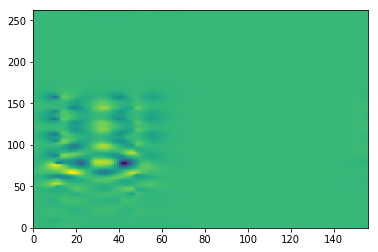

In [40]:
plt.pcolormesh(morb_grids_new[0][1][:, :, 5])
plt.show()

In [43]:
save_morb = morb_grids_new[1][2]

cu.write_cube_file("/home/kristjan/local_work/morbs_test/test.cube",
                   ase_atoms, new_cell, save_morb.shape, save_morb, origin = origin)

In [17]:
# check for normalization
dv = cell/cell_n
vol_elem = dv[0]*dv[1]*dv[2]
np.sum(morb_grids_new[0][0]**2)*vol_elem

1.0000013846797009